In [56]:
import os
import pandas as pd
from file_merge import merge_data_from_folder
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import requests


In [5]:
folder_path = r'C:\Users\Romario Mason\OneDrive\Documents\GitHub\Portfolio_23\Forecasting\Divvy Bikes\Data'

# Merge the data files and assign to a DataFrame
merged_data = merge_data_from_folder(folder_path)

# Print the merged DataFrame
print(merged_data)

                  ride_id  rideable_type           started_at  \
0        EC2DE40644C6B0F4   classic_bike  2022-05-23 23:06:58   
1        1C31AD03897EE385   classic_bike  2022-05-11 08:53:28   
2        1542FBEC830415CF   classic_bike  2022-05-26 18:36:28   
3        6FF59852924528F8   classic_bike  2022-05-10 07:30:07   
4        483C52CAAE12E3AC   classic_bike  2022-05-10 17:31:56   
...                   ...            ...                  ...   
5859056  8B441A6C436E9900   classic_bike  2023-04-29 21:20:21   
5859057  3980D64BE11540F1   classic_bike  2023-04-24 09:16:05   
5859058  3EF4B49FF7DAA02C   classic_bike  2023-04-18 07:53:51   
5859059  210B2ED6583DC231   classic_bike  2023-04-29 07:33:55   
5859060  D29CB39B9E3FC46A  electric_bike  2023-04-18 08:00:32   

                    ended_at                 start_station_name  \
0        2022-05-23 23:40:19             Wabash Ave & Grand Ave   
1        2022-05-11 09:31:22  DuSable Lake Shore Dr & Monroe St   
2        2022-05-2

In [62]:
import pandas as pd
import requests

def get_daily_temperatures(df, lat_column, lng_column, api_key):
    # Create a new column to store the temperature
    df['temperature'] = None

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        start_time = row['started_at']
        lat = row[lat_column]
        lng = row[lng_column]

        # Extract the date from the start_time column
        date = start_time.date()

        # Make a request to OpenWeatherMap API
        url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lng}&appid={api_key}"
        response = requests.get(url)
        data = response.json()

        # Extract the temperature from the response
        if 'main' in data and 'temp' in data['main']:
            temperature = data['main']['temp']
            # Convert temperature from Kelvin to Celsius
            temperature_celsius = temperature - 273.15
            df.at[index, 'temperature'] = temperature_celsius

    # Calculate the average temperature per day
    df['date'] = pd.to_datetime(df['started_at']).dt.date
    df['average_temperature'] = df.groupby('date')['temperature'].transform('mean')

    return df


In [ ]:
api_key = '781c1c1db6188d3efbcac8f86c979a51'

# Call the function to get daily temperatures and average temperature per day
merged_data_with_temperatures = get_daily_temperatures(merged_data, 'start_lat', 'start_lng', api_key)

# Print the DataFrame with temperature data
print(merged_data_with_temperatures)

In [21]:
def aggregate_rides_per_day(df):
    # Convert 'started at' column to datetime format
    df['started_at'] = pd.to_datetime(df['started_at'])

    # Extract the date from 'started at' column
    df['date'] = df['started_at'].dt.date

    # Group the data by 'date' and 'member_casual', and count the rides
    rides_per_day = df.groupby(['date', 'member_casual']).size().unstack(fill_value=0)

    # Reset the index to bring 'date' as its own column
    rides_per_day = rides_per_day.reset_index()

    return rides_per_day

In [69]:

rides_aggregated = aggregate_rides_per_day(merged_data)

# Print the aggregated rides data
print(rides_aggregated)

member_casual        date  casual  member
0              2022-05-01    5113    7283
1              2022-05-02    3734   10016
2              2022-05-03    1408    4609
3              2022-05-04    4536   11081
4              2022-05-05    2367    7162
..                    ...     ...     ...
360            2023-04-26    3634   10578
361            2023-04-27    5656   12639
362            2023-04-28    4994   10409
363            2023-04-29    4835    7110
364            2023-04-30    2491    4876

[365 rows x 3 columns]


In [23]:
def plot_aggregated_data(rides_aggregated):
    # Create the time series graph
    plt.figure(figsize=(12, 6))
    rides_aggregated.plot(marker='o', linestyle='-', linewidth=2)

    plt.title('Divvy Bike Rides - Total Rides per Day')
    plt.xlabel('Date')
    plt.ylabel('Total Rides')
    plt.legend(title='Member Type')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def analyze_trend(df, date_column, data_column):
    # Convert the date column to datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Sort the DataFrame by the date column
    df = df.sort_values(date_column)

    # Calculate the trend by computing the slope of the trend line
    trend = df[data_column].diff().sum()

    if trend > 0:
        trend_status = "Trending Up"
    elif trend < 0:
        trend_status = "Trending Down"
    else:
        trend_status = "No Clear Trend"

    return trend_status

In [51]:
def detect_seasonality(rides_aggregated, member_type):
    # Select the rows for the specified member type
    rides_data = rides_aggregated.loc[rides_aggregated['member'] == member_type]

    # Convert 'date' column to datetime format and set as index
    rides_data['date'] = pd.to_datetime(rides_data['date'])
    rides_data.set_index('date', inplace=True)

    # Perform seasonal decomposition analysis
    result = seasonal_decompose(rides_data, model='additive')

    # Extract the seasonal component
    seasonal_component = result.seasonal

    # Check if there is seasonality
    has_seasonality = any(abs(seasonal_component) > 0.1)

    return has_seasonality

In [ ]:
member_type = 'casual'
has_seasonality = detect_seasonality(rides_aggregated, member_type)

# Print the seasonality result for the specified member type
if has_seasonality:
    print(f"Seasonality is present in the {member_type} data.")
else:
    print(f"No significant seasonality is detected in the {member_type} data.")

In [26]:
date_column = 'date'
casual_trend = analyze_trend(rides_aggregated, date_column, 'casual')
member_trend = analyze_trend(rides_aggregated, date_column, 'member')

# Print the trend analysis results
print("Casual Trend Analysis:", casual_trend)
print("Member Trend Analysis:", member_trend)

Casual Trend Analysis: Trending Down
Member Trend Analysis: Trending Down


<Figure size 864x432 with 0 Axes>

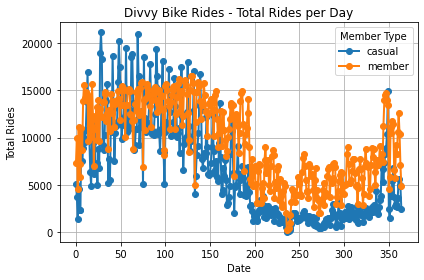

In [55]:
plot_aggregated_data(rides_aggregated)

In [65]:
#Drop temperature column
rides_aggregated.drop('temperature', axis=1, inplace=True)

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def predict_rides(rides_aggregated):
    # Convert 'date' column to datetime format
    rides_aggregated['date'] = pd.to_datetime(rides_aggregated['date'])

    # Set 'date' column as the index
    rides_aggregated.set_index('date', inplace=True)

    # Create an empty DataFrame to store the predictions
    predictions = pd.DataFrame(columns=['Casual', 'Member'])

    # Iterate over the unique dates
    for date in rides_aggregated.index.unique():
        # Select the data for the current date
        data = rides_aggregated.loc[date]

        # Create the SARIMAX model for 'Casual' column
        model_casual = SARIMAX(data['Casual'], order=(1, 1, 1))
        result_casual = model_casual.fit()

        # Create the SARIMAX model for 'Member' column
        model_member = SARIMAX(data['Member'], order=(1, 1, 1))
        result_member = model_member.fit()

        # Forecast the values for the next day
        forecast_casual = result_casual.forecast(steps=1)
        forecast_member = result_member.forecast(steps=1)

        # Store the predictions in the DataFrame
        predictions.loc[date] = [forecast_casual[0], forecast_member[0]]

    return predictions

In [ ]:
# Call the function to predict the values for 'Casual' and 'Member'
predicted_rides = predict_rides(rides_aggregated)

# Print the predicted values
print(predicted_rides)